# p-mode envelope detection
This is a notebook describing a potential method of evaluating the probability that a p-mode envelope is detected in the power spectrum of a solar-like oscillator.

This method evaluates the probability that a p-mode envelope is present at a $\nu_{max}=\nu_i$ for $i=0,1,2..N$. Where $N$ is the number of frequency bins to be investiaged. 

At each frequency, the power in the spectrum is summed over a range equivalent to the estimated with of a p-mode envelope at that frequency, based on predictions from scaling relations. This summed power is then compared to the sum of the background and a predicted p-mode envelope, with a width and height estimated by scaling relations, given a value of $T_{eff}$ of the star in question.

We'll start with some imports.

In [2]:
import numpy as np
from matplotlib.pyplot import *
import lightkurve as lk
from scipy.stats import chi2

### Time series selection
First we select a potential target. KIC8006161 is a solar-like oscillator with numax $\approx3500\mu$Hz. 

In [3]:
lcs = lk.search_lightcurvefile('KIC8006161', cadence = 'short', mission = 'Kepler').download_all()

This star is also fairly active, so in the PDC lightcurve the activity should probably be at least partially filtered with a running median filter. We also remove nans, and outliers at 5 sigma. Lightkurve doesn't automatically set the flux units to ppm and zero mean, so we also scale the array of flux values.  

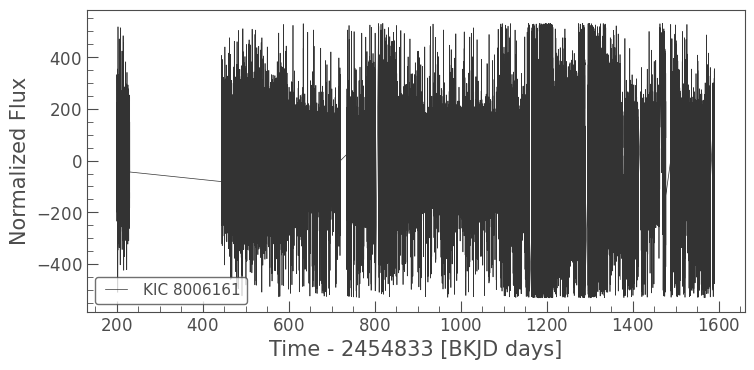

In [4]:
lc  = lcs.PDCSAP_FLUX.stitch().remove_nans().flatten(window_length = 2001).remove_outliers(5)
lc.flux = (lc.flux-1)*1e6 # scale to ppm and zero mean.
lc.plot()

### Power spectrum
Next we compute the power spectrum of the above time series. The power should be normalized to $ppm^2/\mu$Hz, which Lightkurve doesn't do by default.

In [5]:
pg = lc.to_periodogram(normalization = 'psd')
dt = np.median(np.diff(lc.time))*60*60*24/1e6
pg.power = pg.power / np.mean(pg.power) * (2*np.std(lc.flux)**2 * dt) 
f, p = pg.frequency.value, pg.power.value

In the following we will also need an estimate of the background level. This can be done using a log(frequency) median filter. Here we use a filter width of 0.1 dex (I think), this value might need to be tweaked. 

In [6]:
snr, bkg = pg.flatten(filter_width = 0.1, return_trend=True)
b = bkg.power.value

We can plot the resulting power spectrum and the estimate of the background component. A smaller filter_width on the median filter makes the background more senstive to modes in the envelope. On the other hand a wider filter causes the jagged pattern seen near the sharper features in the spectrum. Perhaps a different method of estimating the background can be chosen? Warrick has several. 

Notice the relatively sharp feature at $\approx200\mu$Hz. This will cause problems later on. 

Text(0, 0.5, 'ppm$^2/\\mu$Hz')

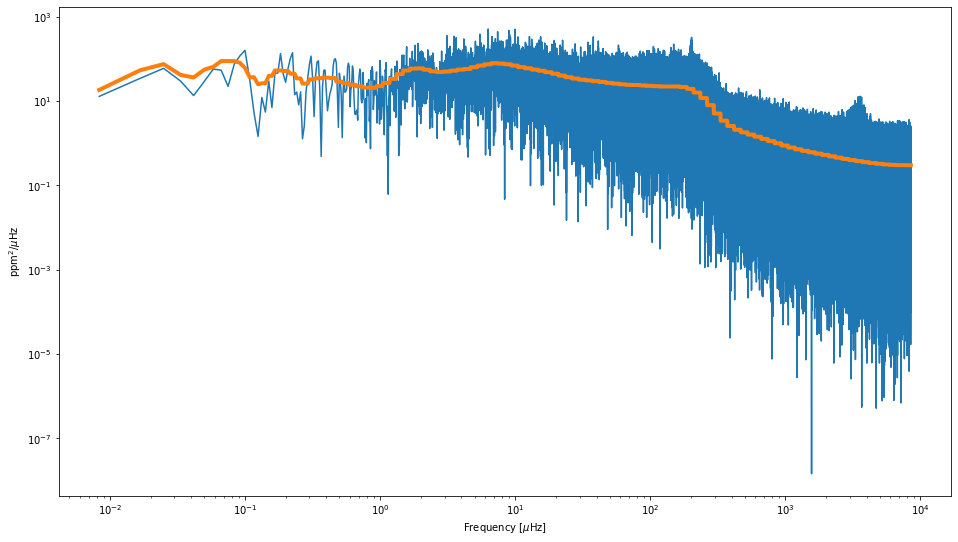

In [7]:
fig, ax = subplots(figsize = (16,9))
ax.loglog(f, p, label = 'Power spectrum')
ax.loglog(f, b, label = 'Estimate of the background component of the power', lw = 4)
ax.set_xlabel(r'Frequency [$\mu$Hz]')
ax.set_ylabel(r'PSD [ppm$^2/\mu$Hz]')

The next step is to bin the spectrum. We start by defining a generic binning function.

In [8]:
def bin_this(x, n):
    """ Bin x by a factor n
    
    If len(x) is not equal to an integer number of n, 
    the remaining frequency bins are discarded. 
    Half at low frequency and half at high frequency. 
    
    Parameters
    ----------
    x : array
        Array of values to bin.
    n : int
        Binning factor
    
    Returns
    -------
    xbin : array
        The binned version of the input array
    """
    
    trim = (len(x)//n)*n # The input array isn't always an integer number of the binning factor
    half_rest = (len(x)-trim)//2 
    x = x[half_rest:half_rest+trim] # Trim the input array
    xbin = x.reshape((-1, n)).mean(axis = 1) # reshape and average 
    return xbin

The binning factor is chosen in terms of $\mu$Hz and should be large to smooth out the envelope. Note that small binning factors will make computations very slow. For short cadence binning $>10\mu$Hz or more is probably best?

In [9]:
df = f[1]-f[0] # The frequency resolution of the unbinned spectrum
Nbin = int(20 / df) # Binning factor

We can now bin the arrays

In [11]:
fb = bin_this(f, Nbin) # Rebinned frequencies
pb = bin_this(p, Nbin) # Rebinned spectrum
bb = bin_this(b, Nbin) # Rebinned background estimate

dfb = fb[1] - fb[0] # Frequency resolution after binning

### Computing the predicted p-mode envelopes.
The next step is to compute the predicted p-mode envelopes. This step can probably be optimized considerably, so that a smaller bin-size can be selected above. 

In [59]:
def pmode_env(f, numax, Teff):
    """ p-mode envelope as a function of frequency.
    
    The p-mode envelope is assumed to be a Guassian.
    
    Parameters
    ----------
    f : array
        Frequency bins in the spectrum
    numax : float
        Frequency to place the p-mode envelope at. 
    Teff : float
        Effective temperature of the star
    
    Returns
    -------
    envelope : array
        Predicted Guassian p-mode envelope.
    """
    
    Henv = env_height(numax, Teff)
    stdenv = env_width(numax) / 2.*np.sqrt(2.*np.log(2.))
    envelope = Henv*np.exp(-(f-numax)**2/(2*stdenv**2))
    return envelope

def env_height(numax, Teff, Henv_sun=0.1):
    """ Scaling relation for the envelope height
    
    Parameters
    ----------
    numax : float
        Frequency of maximum power of the p-mode envelope. 
    Teff : float
        Effective temperature of the star
    Henv_sun: float, optional
        Envelope height for the Sun. Default is 0.1 ppm^2/muHz.

    Returns
    -------
    Henv : float
        Height of the p-mode envelope
    """
    
    Tred = 8907.*(numax/3090.)**0.11*(Teff/5777.)**-0.47
    beta = 1.0 - np.exp(-(Tred-Teff)/1250.)
    Henv = Henv_sun*beta**2*(numax/3090.)**-2.79*(Teff/5777.)**3  
    return Henv
    
def env_width(numax):
    """ Scaling relation for the envelope height
    
    Currently just a crude estimate. This can probably 
    be improved.
    
    Parameters
    ----------
    numax : float
        Frequency of maximum power of the p-mode envelope.
    
    Returns
    -------
    
    width : float
        Envelope width in muHz
    
    """
    
    width = numax/4
    return width

To make a semi-realistic estimate of what the p-mode envelope looks like we need to know the effective temperature of the star. KIC8006161 has a temperature of 5340K. 

We can then proceed to compute the predicted p-mode envelopes for all the frequencies in the binned power spectrum.

In [60]:
Teff = 5340
Hgau = np.array([pmode_env(fb, nu, Teff) for nu in fb])

This detection method relies on summing power in a frequency range around a test-value of numax, which is equivalent to the expected envelope width. With the function above we can estimate this frequency range and give it as a boolean array.

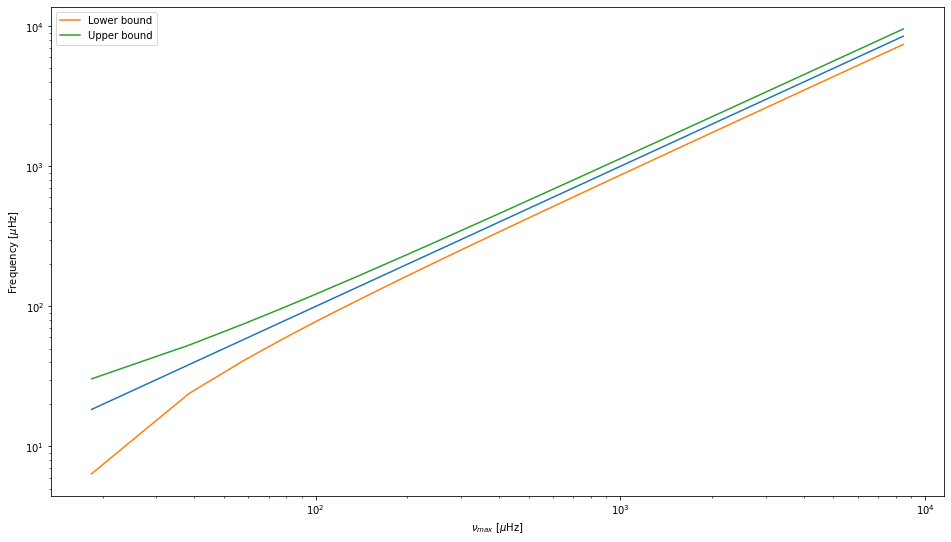

In [61]:
l = fb - (env_width(fb).astype(int) + dfb)/2  # offset equal to 1 frequency bin to avoid issues at array start and end
u = fb + (env_width(fb).astype(int) + dfb)/2
env_range = np.array([(l[i] < fb) & (fb < u[i]) for i in range(len(fb))] )

fig, ax = subplots(figsize = (16,9))
ax.loglog(fb,fb)
ax.loglog(fb, l, label = 'Lower bound')
ax.loglog(fb, u, label = 'Upper bound')
ax.set_xlabel(r'$\nu_{max}$ [$\mu$Hz]')
ax.set_ylabel(r'Frequency [$\mu$Hz]')
ax.legend()

The current method for calculating the envelope width is pretty crude, and is currently just a scaling of $\nu_{max}$. A small offset is applied to make sure the envelope width is equal to at least 1 frequency bin. This is only important at low frequencies.

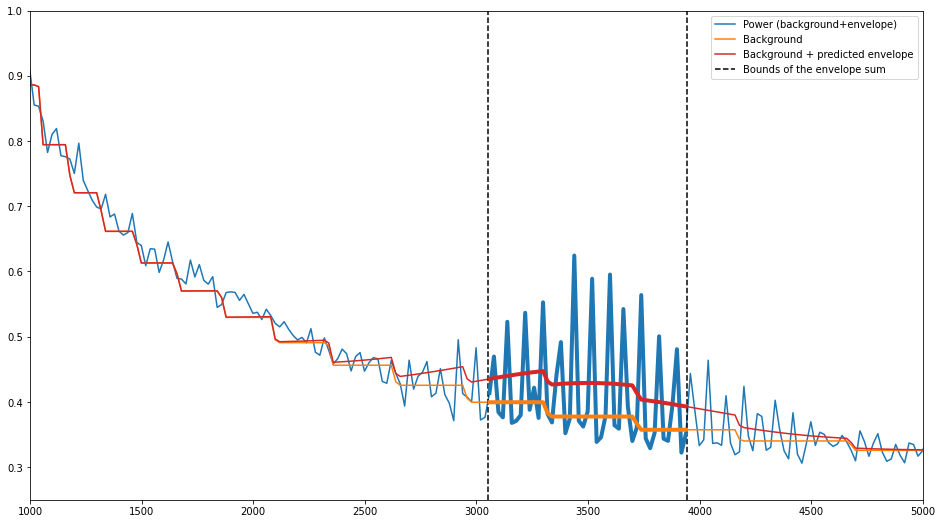

In [62]:
numax = 3500 # for display purposes
idx = np.argmin(abs(fb-numax))

fig, ax = subplots(figsize = (16,9))
ax.plot(fb, pb, label = 'Power (background+envelope)')
ax.plot(fb, bb, label = 'Background', color = 'C1')
ax.plot(fb, bb+Hgau[idx,:], label = 'Background + predicted envelope', color = 'C3')
ax.axvline(l[idx], color = 'k', ls = 'dashed', label = 'Bounds of the envelope sum')
ax.axvline(u[idx], color = 'k', ls = 'dashed')
ax.plot(fb[env_range[idx,:]], pb[env_range[idx,:]], lw = 4, color = 'C0')
ax.plot(fb[env_range[idx,:]], bb[env_range[idx,:]], lw = 4, color = 'C1')
ax.plot(fb[env_range[idx,:]], bb[env_range[idx,:]]+Hgau[idx,env_range[idx,:]], lw = 4, color = 'C3')
ax.set_ylim(0.25, 1.)
ax.set_xlim(1e3,5e3)
ax.set_xlabel(r'Frequency [$\mu$Hz]')
ax.set_ylabel(r'PSD [ppm$^2/\mu$Hz]')
ax.legend()

Above, the dashed black lines indicate the range that is summed over to compute the detection probability. The SNR at the envelope, computed by comparing the power (blue) to the expected background (orange) is compared to what would be expected from the background and a Gaussian from scaling relations (red). 

The envelope width is perhaps a bit of an underestimate. 

(18.38456289651936, 8478.021621684267)

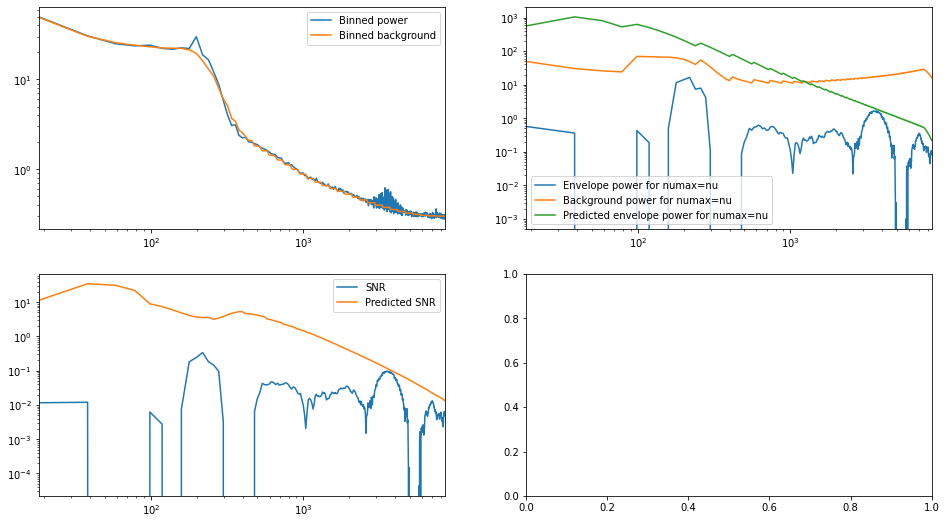

In [63]:
Ptot      = np.array([np.sum(pb[env_range[i]]) - np.sum(bb[env_range[i]]) for i in range(len(fb))])
Btot      = np.array([np.sum(bb[env_range[i]])                 for i in range(len(fb))]) 
Ptot_pred = np.array([np.sum(Hgau[i, env_range[i]])          for i in range(len(fb))])

SNR      = Ptot / Btot
SNR_pred = Ptot_pred / Btot

Text(0, 0.5, 'SNR')

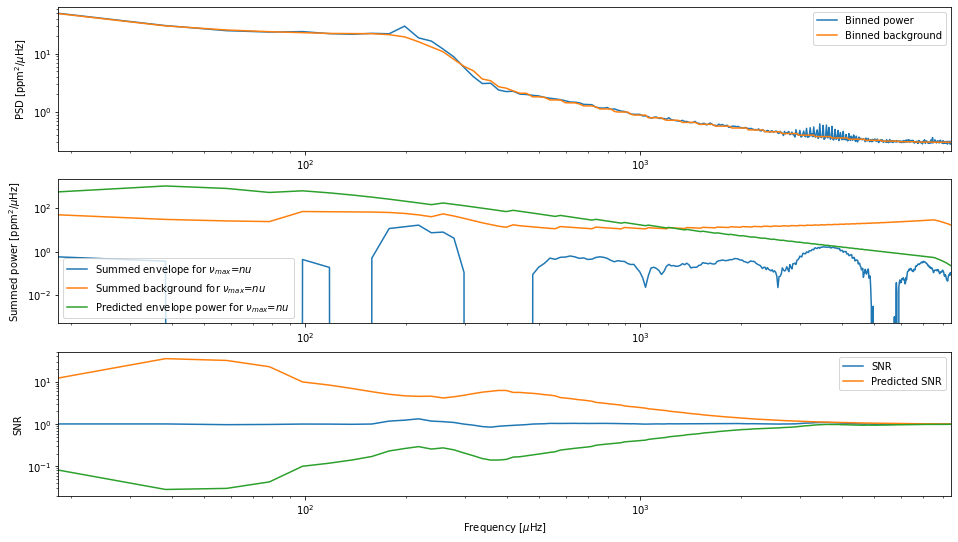

In [80]:
fig, ax = subplots(3,1, figsize = (16,9))
ax[0].loglog(fb, pb, label = 'Binned power')
ax[0].loglog(fb, bb, label = 'Binned background')
ax[0].legend()
ax[0].set_xlim(min(fb),max(fb))
#ax[0].set_xlabel(r'Frequency [$\mu$Hz]')
ax[0].set_ylabel(r'PSD [ppm$^2/\mu$Hz]')

ax[1].loglog(fb, Ptot, label = r'Summed envelope for $\nu_{max}$=$nu$')
ax[1].loglog(fb, Btot, label = r'Summed background for $\nu_{max}$=$nu$')
ax[1].loglog(fb, Ptot_pred, label = r'Predicted envelope power for $\nu_{max}$=$nu$')
ax[1].legend()
ax[1].set_xlim(min(fb),max(fb))
#ax[1].set_xlabel(r'Frequency [$\mu$Hz]')
ax[1].set_ylabel(r'Summed power [ppm$^2/\mu$Hz]')                 

ax[2].loglog(fb, SNR+1, label = 'SNR')
ax[2].loglog(fb, SNR_pred+1, label = 'Predicted SNR')
ax[2].loglog(fb, (1 + SNR)/(1 + SNR_pred))
ax[2].legend()
ax[2].set_xlim(min(fb),max(fb))
ax[2].set_xlabel(r'Frequency [$\mu$Hz]')
ax[2].set_ylabel(r'SNR')                 


In [64]:
like0 = chi2.sf( 1 + SNR                 , 2*Nbin, scale=0.5/Nbin)
like1 = chi2.sf((1 + SNR)/(1 + SNR_pred) , 2*Nbin, scale=0.5/Nbin)

prior0 = np.ones_like(like0)*0.5
prior1 = np.ones_like(like0)*0.5

post = prior1*like1/(prior0*like0+prior1*like1)

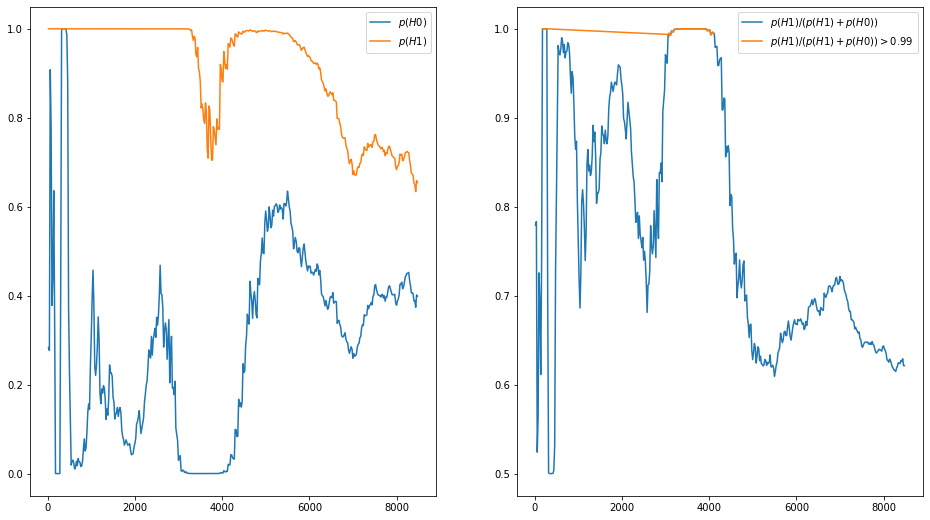

In [65]:
thresh = 0.99

fig, ax = subplots(1,2, figsize = (16,9))
ax[0].plot(fb, p0, label = '$p(H0)$')
ax[0].plot(fb, p1, label = '$p(H1)$')
ax[0].legend()

ax[1].plot(fb, post, color = 'C0', label = '$p(H1)/(p(H1)+p(H0))$')
ax[1].plot(fb[post > thresh], post[post > thresh], color = 'C1', label = f'$p(H1)/(p(H1)+p(H0)) > {thresh}$')
ax[1].legend()

In [ ]:
import pandas as pd
df = pd.read_csv('/home/nielsemb/work/the_big_solar_like_oscillator_list.csv')

In [ ]:
idx = (4750-200 < df['teff']) & (df['teff'] < 4750+200)

In [ ]:
figure(figsize = (16,9))
scatter(np.log10(df['teff']), np.log10(df['numax']), )
scatter(np.log10(df['teff'][idx]), np.log10(df['numax'][idx]), )

In [ ]:
import pickle
s = pickle.load(open( "/home/nielsemb/work/search_result_g.p", "rb" ) )

In [ ]:
gf = s.GDR2.to_pandas()

In [ ]:
def absMag(m, A, plx):
    M = (m-A) - (5*np.log10(1./plx)-5)
    return M

s.GDR2['a_g_val'][np.isnan(s.GDR2['a_g_val'])] = 0
MG = absMag(s.GDR2['phot_g_mean_mag'], s.GDR2['a_g_val'], s.GDR2['parallax']*1e-3)

In [ ]:
bp_rp_ = 1.2312 # 0.1)
MG_ = absMag(11.5488, 0, 1.5787*1e-3)
numax_ = 218

In [ ]:
df[df['ID']=='KIC4448777']

In [ ]:
gf.loc[2358, 'a_g_val']

In [ ]:
idx0 = (bp_rp_-0.1 < s.GDR2['bp_rp']) & (s.GDR2['bp_rp'] < bp_rp_ + 0.1)
idx1 = (MG_ - 0.1 < MG) & (MG < MG_ + 0.1)
df['numax'][idx0&idx1]
#np.median(df['numax'][idx0&idx1])

In [ ]:
fig, ax = subplots(figsize = (16,9))
#c = ax.scatter(np.log10(s.GDR2['bp_rp']), MG, c = np.log10(df['numax']) )
colorbar(c)
ax.scatter(np.log10(s.GDR2['bp_rp'][idx0&idx1]), MG[idx0&idx1], c = np.log10(df['numax'][idx0&idx1]) )
#ax.plot(np.log10(bp_rp_), np.log10(numax_), 'o', c = 'C3')

In [ ]:
fig, ax = subplots(figsize = (16,9))
c = ax.scatter(np.log10(s.GDR2['bp_rp']), np.log10(df['numax']), c= MG )
colorbar(c)
ax.plot(np.log10(bp_rp_), np.log10(numax_), 'o', c = 'C3')

In [ ]:
numax = 220  
Teff = 4750
df = f[1]-f[0]

In [ ]:
def pmode_env(f, numax, Teff, width, Henv_sun=0.1):
    
    FWHM_STD = 2.*np.sqrt(2.*np.log(2.))
    STD_FWHM = 1.0/FWHM_STD
    
    Tred = 8907.*(numax/3090.)**0.11*(Teff/5777.)**-0.47
    beta = 1.0 - np.exp(-(Tred-Teff)/1250.)
    Henv = Henv_sun*beta**2*(numax/3090.)**-2.79*(Teff/5777.)**3
    
    FWHMenv = env_width(numax, 4). # FWHM, 770.*(numax/3090.)
    stdenv = FWHMenv*STD_FWHM
    Hgau = Henv*np.exp(-(f-numax)**2/(2*stdenv**2))
    
    # Number of bins in the p-mode envelope
    Ns = int(2.*FWHMenv/df*width)
    
    return Hgau, Ns

In [ ]:
def hypothesis_total(f, p, b, numax, Teff, full_output=False, width=1, Amax_sun=3.0, Henv_sun=0.1, form='bill',
                     threshold=0.999):
    """Run Bill's hypothesis testing method to decide if oscillations have been detected.
    """
    
    Hgau, Ns = pmode_env(f, numax, Teff, width, Henv_sun)

    df = f[1]-f[0]  # assumes no oversampling, (16)
    
    pb = bin(p, Ns) # The binned spectrum
    bb = bin(b, Ns) # The binned background estimate
    gb = bin(b + Hgau, Ns) # The binned background + probable Gaussian estimate
        
    figure()
    plot(f, np.log10(pb))
    plot(f, np.log10(bb))
    plot(f, np.log10(gb))
    s = 0.5/Ns
    
    snr = pb/bb
    # these appear to be equivalent...
    if form == 'bill':
        SNR_thr = chi2.ppf(threshold, 2*Ns, scale=s)
        Like0   = chi2.sf(1+snr       , 2*Ns, scale=s)
        Like1   = chi2.sf((1+snr)/ (1+pb/gb)     , 2*Ns, scale=s)
        
    elif form == 'warrick':
        SNR_thr = chi2.ppf(threshold, 2*Ns, scale=pb*s)
        Like0   = chi2.sf(pb        , 2*Ns, scale=bb*s)
        Like1   = chi2.sf(pb        , 2*Ns, scale=gb*s)
        
    else:
        raise ValueError("form must be 'bill' or 'warrick', not '%s'" % form)
    
    print(SNR_thr)
    
    Prior0 = 0.5*np.ones_like(f)
    Prior1 = 1.0 - Prior0
    Post1 = Prior1*Like1/(Prior0*Like0 + Prior1*Like1)

    Prior1 = chi2.sf(SNR_thr, 2*Ns, scale=gb/2./Ns)
    Prior0 = 1.0 - Prior1
    
    Post2 = Prior1*Like1/(Prior0*Like0 + Prior1*Like1)
    
    return Like0, Like1, Prior0, Prior1, Post1, Post2, Hgau, Ns

In [ ]:
Like0, Like1, Prior0, Prior1, Post1, Post2, Hgau, Ns = hypothesis_total(f, p, b, numax, Teff) #

In [ ]:
figure(figsize = (16,9))
plot(f, Post1)
plot(f, Post2)
#yscale('log')

In [ ]:
def FFT_ACF(x, return_half=True, axis=-1, **kwargs):
    """Compute the autocorrelation function (ACF) of `x` using NumPy's
    fast Fourier transform.  By default, only returns half the ACF.
    For the full ACF, use `return_half=False`.

    Extra keyword arguments are passed to `numpy.fft.fft` and
    `numpy.fft.ifft`.

    """
    F = np.fft.fft(x, axis=axis, **kwargs)
    if return_half:
        return np.real(np.fft.ifft(F*np.conj(F), axis=axis, **kwargs))[:len(F)//2]
    else:
        return np.real(np.fft.ifft(F*np.conj(F), axis=axis, **kwargs))


def scan_ACF(f, y, start, stop, step, width):
    """Compute the autocorrelation function (ACF) of regularly-spaced
    segments of the input data.  The ACF is computed using the fast
    Fourier transform, so it's assumed that the data are evenly spaced
    in frequency.

    Parameters
    ----------
    f: array
        Frequency range of the data.
    y: array
        Data for ACF (usually power spectrum or SNR spectrum).
    start: float
        Lower frequency limit of the scan.
    end: float
        Upper frequency limit of the scan.
    step: float
        Size of frequency step between each segment.
    width: int
        Width, in units of `step`, of each segment of data.

    Returns
    -------
    x: array
        `x` co-ordinates of ACF array.
    y: array
        `y` co-ordinates of ACF array.
    ACFs: 2-d array
        Array containing the ACF of each segment of data, stacked.

    """
    bw = f[1]-f[0]
    
    width_i = width*int(step/bw)
    I = np.arange(int((start-f[0])/bw), int((stop-f[0])/bw), int(step/bw))
    
    ACFs = np.zeros((len(I), width_i))
    for j, i in enumerate(I):
        chunk = y[i:i + 2*width_i]        
        ACFs[j] = correlate(chunk, chunk, mode = 'same')[:len(chunk)//2][::-1] # FFT_ACF(chunk)
        
    return f[I + width_i//2], np.arange(len(chunk)//2)*(f[1]-f[0]), ACFs

In [ ]:
w = 5
step = w

x, y, z = scan_ACF(f, p, f[0], f[-1]-2*step*w, step, w)

figure()
imshow(np.log10(z.T), extent=[x[0], x[-1], y[0], y[-1]], origin='lower', aspect='auto')